# Lab 4: Machine Learning with Vertex AI

Author: Fabian Hirschmann, Wissem Khlifi

Welcome back 👋😍. During this lab, you will train a machine learning model on the data set you already know. Then, we will create a MLOps pipeline to automate this process.

In a Jupyter Notebook, you can press `Shift + Return` to execute the current code junk and jump to the next one.

First, let's set a few variables and perform some Python imports

In [ ]:
import random
random.seed(1337)

from google.cloud import aiplatform, bigquery
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

project = !gcloud config get-value project
PROJECT_ID = project[0]

REGION = "us-central1"
BQ_DATASET = "ml_datasets"
BQ_TABLE = "ulb_fraud_detection_dataproc"
BQ_SOURCE = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}"

The next chunk represents the source table in BigQuery we will be working with.

In [146]:
BQ_SOURCE

'888342260584.ml_datasets.ulb_fraud_detection_dataproc'

Let's have a look at the data.

In [167]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"{PROJECT_ID}-bucket")
bq = bigquery.Client(project=PROJECT_ID, location=REGION)

In [148]:
data = bq.query(f"SELECT * FROM `{BQ_SOURCE}`").to_dataframe()

In [149]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.00,0
1,14332.0,1.071950,0.340678,1.784068,2.846396,-0.751538,0.403028,-0.734920,0.205807,1.092726,...,-0.169632,-0.113604,0.067643,0.468669,0.223541,-0.112355,0.014015,0.021504,0.00,0
2,32799.0,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,0.125514,0.480049,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.00,0
3,35799.0,-0.769798,0.622325,0.242491,-0.586652,0.527819,-0.104512,0.209909,0.669861,-0.304509,...,0.152738,0.255654,-0.130237,-0.660934,-0.493374,0.331855,-0.011101,0.049089,0.00,0
4,36419.0,1.047960,0.145048,1.624573,2.932652,-0.726574,0.690451,-0.627288,0.278709,0.318434,...,0.078499,0.658942,-0.067810,0.476882,0.526830,0.219902,0.070627,0.028488,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,154599.0,0.667714,3.041502,-5.845112,5.967587,0.213863,-1.462923,-2.688761,0.677764,-3.447596,...,0.329760,-0.941383,-0.006075,-0.958925,0.239298,-0.067356,0.821048,0.426175,6.74,1
284803,90676.0,-2.405580,3.738235,-2.317843,1.367442,0.394001,1.919938,-3.106942,-10.764403,3.353525,...,10.005998,-2.454964,1.684957,0.118263,-1.531380,-0.695308,-0.152502,-0.138866,6.99,1
284804,34634.0,0.333499,1.699873,-2.596561,3.643945,-0.585068,-0.654659,-2.275789,0.675229,-2.042416,...,0.469212,-0.144363,-0.317981,-0.769644,0.807855,0.228164,0.551002,0.305473,18.96,1
284805,96135.0,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,-2.516752,...,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,18.96,1


In [150]:
target = data["Class"]
data.drop("Class", axis=1, inplace=True)

In [151]:
target.value_counts()

Class
0    284315
1       492
Name: count, dtype: Int64

In [152]:
x_train, x_test, y_train, y_test = train_test_split(data, target, train_size = 0.80)

In [153]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=50)

In [154]:
clf.fit(x_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


RandomForestClassifier(n_estimators=50, n_jobs=50)

In [155]:
preds = clf.predict(x_test)

In [156]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

In [157]:
metrics.auc(fpr, tpr)

0.8867660703903407

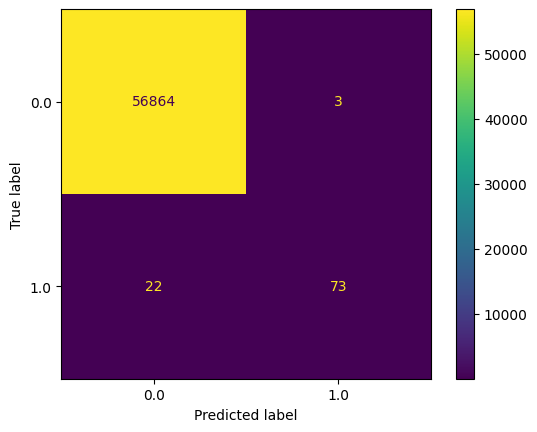

In [135]:
cm = metrics.confusion_matrix(y_test, preds, labels=model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [189]:
%%writefile train.py
#!/usr/bin/env python
import os
from pprint import pprint
pprint(dict(os.environ))
import joblib
import random
random.seed(1337)

from google.cloud import aiplatform, bigquery
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

aiplatform.init(project=os.environ["CLOUD_ML_PROJECT_ID"],
                location=os.environ["CLOUD_ML_REGION"],
                staging_bucket=os.environ["AIP_MODEL_DIR"].split("/")[2])
bq = bigquery.Client(project=os.environ["CLOUD_ML_PROJECT_ID"])

BQ_SOURCE = os.environ["CLOUD_ML_PROJECT_ID"] + ".ml_datasets.ulb_fraud_detection_dataproc"
data = bq.query(f"SELECT * FROM `{BQ_SOURCE}`").to_dataframe()
target = data["Class"]
data.drop("Class", axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data, target, train_size = 0.80)
clf = RandomForestClassifier(n_estimators=50, n_jobs=50)
clf.fit(x_train, y_train)

joblib.dump(clf, os.path.join(os.environ["AIP_MODEL_DIR"], "model.pkl"))

Overwriting train.py


In [190]:
job = aiplatform.CustomTrainingJob(
    display_name="bootkon-model",
    script_path="train.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.1-0:latest",
    requirements=["google-cloud-bigquery", "db-dtypes"], # python packages to install (pip style)
)

Let's run the training job! 

In [ ]:
job.run(
    machine_type="e2-standard-4",
    replica_count=1,
)

While it is running, please go to the [Vertex AI Console](https://console.cloud.google.com/vertex-ai/training/training-pipelines) and click on the training job where you see **Status: Training**. The training job is based on a more general concept called `CustomJob`, and it adds functionality such as automatic model upload to Cloud Storage and registering the model to the model registry. Hence, to see details about the running job, click on the **Custom Job** and then **View Logs**.

---
## Create Dataset (link to BigQuery table)

### Explanation of Using Vertex AI Dataset Over Directly Using BigQuery Dataset
- Seamless Integration and Preprocessing : By creating a dataset in Vertex AI, you enable seamless integration with other Vertex AI tools and services. This ensures that data is correctly formatted and optimized for machine learning tasks within Vertex AI.
- Automated Preprocessing : Vertex AI AutoML handles much of the preprocessing required for machine learning automatically. This includes handling missing values, normalizing data, and encoding categorical variables. Directly using a BigQuery dataset would require manual preprocessing.

In summary, creating a dataset in Vertex AI provides a robust and integrated environment for machine learning that enhances preprocessing, training, and management capabilities. It leverages the power of BigQuery for data storage while taking advantage of Vertex AI’s advanced ML features, leading to more efficient and effective model development and deployment.



### Train Model with AutoML

In [16]:
# Define column specifications by excluding omitted variables, the target variable, and the split column.
# This ensures the model focuses only on relevant features.

column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))

In [18]:
# Assign default type 'auto' to all columns
# This allows AutoML to automatically infer the data type and handle preprocessing.

column_specs = dict.fromkeys(column_specs, 'auto')

Define a Job:
- Consider Weighting : : Adjusts for class imbalance by assigning weights to classes.
- Model Type: : Specifies the type of model (e.g., classification, regression).
- Optimization Objective: Defines the metric to optimize (e.g., AUC for binary classification). For more details , refer to "Understanding Machine Learning Objectives for Imbalanced Datasets" section of  The FraudFix Use Case PDF.

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [19]:
# Train Model with AutoML
# Vertex AI AutoML uses the linked dataset to train the model. The compute resources for training are provided by Vertex AI.

tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [ ]:
# Run the training job
# this job would take +2 hours,  depending on your infrastcuture
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

## **For the remaining commands in the notebook: Since the pipeline job takes a significant amount of time to complete, we will demonstrate the results of the following commands on stage.**

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.


Setup a model client for the model create by this notebook:

In [22]:
# Print model.resource_name 
# If for any reason, the model.resource_name is not set , then set it with the actual resource name of your trained model. 
# This resource name uniquely identifies your model in Vertex AI.

model.resource_name

'projects/292219499736/locations/us-central1/models/7740686104356978688'

In [23]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [24]:
# List model evaluations and get the first evaluation ID
# list_model_evaluations : This method lists all evaluations associated with the specified model. 
# Evaluations contain metrics and other information about the model's performance.

evaluations = model_client.list_model_evaluations(parent = model.resource_name)

evals = iter(evaluations)
eval_id = next(evals).name

# get_model_evaluation : Once you have the evaluation ID, use this method to retrieve detailed evaluation metrics.

geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [25]:
# Access and print the AUC metric
 # Area under the Precision-Recall curve
#  Retrieve specific metrics such as AUC (Area Under the Precision-Recall Curve) and confusion matrix. These metrics help assess the model's performance.
geteval.metrics['auPrc']

0.99986017

##### - **Interpretation of the Results**:
**Example : (Your results could be different)**

An AUC-PR value of `0.99986017` indicates an excellent model performance. The closer the value is to `1.0`, the better the model is at distinguishing between the positive and negative classes.


In [26]:
# Access and print the confusion matrix
# Print the confusion matrix, which shows how often each class is predicted correctly versus incorrectly. 
# This is useful for understanding the model's accuracy for each class.

for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28132.0, 1.0, 0.0]
True Label =  1  has Predicted labels =  [7.0, 13.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


##### - **Interpretation of the Results**:
**Example : (Your results could be different)**
  - **True Label = 0**: Out of instances truly labeled as `0` (negative class), `28,132` were correctly predicted as `0`, and `1` was incorrectly predicted as `1`.
  - **True Label = 1**: Out of instances truly labeled as `1` (positive class), `7` were incorrectly predicted as `0`, and `13` were correctly predicted as `1`.
  - **True Label = DROPPED**: There are no instances with this label, hence all values are `0`. (No instances were actually labeled as "DROPPED", indicating that this label was not present or was excluded.)
This confusion matrix shows that the model has a high number of true positives and true negatives, indicating good predictive performance, especially in distinguishing the negative class.


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [27]:
# list_model_evaluation_slices : Retrieve evaluation metrics for different slices of the model. 
# Slices can be used to evaluate model performance on different subsets of the data, such as different demographic groups.

slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [28]:
# Iterate through each slice and print its metrics

for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.7986504
Label =  0 has auPrc =  0.99989307


##### - **Interpretation of the Results**: 
**Example : (Your results could be different)**
  - **Label = 1 (Positive Class)**: The AUC-PR for the positive class is `0.7986504`, indicating good but not perfect performance in predicting the positive class.
  - **Label = 0 (Negative Class)**: The AUC-PR for the negative class is `0.99989307`, indicating excellent performance in predicting the negative class.


#### In addition to using the API, Vertex AI's Google Cloud Console offers rich visualizations of these metrics, making it easier to understand and interpret the results.


## Endpoint and Deployment
This section creates an endpoint in Vertex AI where the trained model will be deployed.
An endpoint allows you to serve predictions from your trained model.


In [29]:
# max 10 min
# This step initializes an endpoint where the trained model will be deployed. 
# The endpoint is a managed service that allows you to serve real-time predictions.
#  Labels are used for organizing and managing resources. Here, the notebook identifier is used as a label for easy tracking.

endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/292219499736/locations/us-central1/endpoints/1225601422226096128/operations/4101103914051436544
Endpoint created. Resource name: projects/292219499736/locations/us-central1/endpoints/1225601422226096128
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/292219499736/locations/us-central1/endpoints/1225601422226096128')


In [30]:
# takes 45 min
# Deploy the trained model to the created endpoint. This allows the model to serve predictions.
# Deploy method: This command deploys the trained model to the previously created endpoint. 
# Traffic Percentage :  Specifies the amount of traffic (requests) that should be directed to this model. Here, it's set to 100%, meaning all requests will be handled by this model.
# Machine Type : Specifies the type of machine to be used for serving predictions. This is defined by `DEPLOY_COMPUTE`.
# Replica Count : Determines the number of model instances to be deployed for serving predictions. This ensures high availability and scalability.

endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/292219499736/locations/us-central1/models/7740686104356978688 to Endpoint : projects/292219499736/locations/us-central1/endpoints/1225601422226096128
Deploy Endpoint model backing LRO: projects/292219499736/locations/us-central1/endpoints/1225601422226096128/operations/7785048409240502272
Endpoint model deployed. Resource name: projects/292219499736/locations/us-central1/endpoints/1225601422226096128


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [31]:
# Prepare a record for prediction: instance and parameters lists
# Fetch a sample of test data to use for prediction
# This command fetches a subset of the test data from BigQuery to be used for making predictions with the deployed model.

pred = bigquery.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [32]:
# Display the first few rows of the prediction data
# The `head()` function is used to display the first few rows of the fetched data to verify its structure and contents.

pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Feedback,transaction_id,splits,service_account_email
0,66341.0,-1.975549,-1.606799,0.081444,-2.159326,0.589567,0.334022,0.091121,0.745302,-1.320319,...,-0.817125,1.139974,-0.061121,-0.101225,200.5,0,very satisfied.,6a487bc0-864e-476a-89a3-711a95c3bf40,TEST,292219499736-compute@developer.gserviceaccount...
1,138794.0,1.556636,-0.858618,-1.541472,1.235769,0.142803,0.172018,0.186438,-0.093988,0.434570,...,0.427739,-0.227500,-0.026433,-0.027460,250.0,0,very satisfied.,381e5380-80f7-4b4c-b9f7-de89eda68b89,TEST,292219499736-compute@developer.gserviceaccount...
2,100922.0,1.923291,-0.511650,0.217122,0.583403,-1.043504,-0.428347,-0.946888,-0.055398,2.688932,...,-0.628523,0.441857,-0.045307,-0.039834,39.0,0,very satisfied.,90c3c8af-c5bb-4f4b-9735-a30555ba12c6,TEST,292219499736-compute@developer.gserviceaccount...
3,151295.0,-2.663683,2.410267,-0.956647,-1.124388,-0.477937,-0.984630,0.318403,0.709386,1.257919,...,0.370005,0.166635,0.867921,0.614288,20.0,0,very satisfied.,3f04990a-c791-43b6-9af6-78d786fe3ef6,TEST,292219499736-compute@developer.gserviceaccount...


In [33]:
# Prepare a record for prediction: instance and parameters lists

# Select the necessary columns for prediction and convert the data to the required format.
# This step filters out columns that should not be included in the prediction request.
# This step selects the necessary columns from the test dataset, excluding omitted variables, the target variable, and the split column.
# The selected data is converted to a dictionary format, which is required for the prediction request.

newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]

# Display the prepared observation for prediction
newob

{'Time': 66341.0,
 'V1': -1.9755488634109497,
 'V2': -1.6067992448806763,
 'V3': 0.08144358545541763,
 'V4': -2.1593263149261475,
 'V5': 0.5895673036575317,
 'V6': 0.3340217173099518,
 'V7': 0.0911206379532814,
 'V8': 0.7453022599220276,
 'V9': -1.320319414138794,
 'V10': -0.8474969267845154,
 'V11': -0.21961548924446106,
 'V12': 0.6278647780418396,
 'V13': 0.5759356021881104,
 'V14': 0.2245824933052063,
 'V15': -0.3175048232078552,
 'V16': -2.3535516262054443,
 'V17': 1.0250015258789062,
 'V18': -1.37712824344635,
 'V19': -3.5953450202941895,
 'V20': -0.11362418532371521,
 'V21': 0.07117960602045059,
 'V22': -0.009378469549119473,
 'V23': 0.5989304780960083,
 'V24': -0.9059162735939026,
 'V25': -0.8171247243881226,
 'V26': 1.139973521232605,
 'V27': -0.06112143024802208,
 'V28': -0.10122473537921906,
 'Amount': 200.5}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [34]:
# Convert the prepared observation to JSON format required by the prediction endpoint.
#  The prepared observation is converted to JSON format using `json_format.ParseDict()`. This format is required by the Vertex AI prediction endpoint.
# An empty parameters dictionary is created, which can be used if the prediction request requires additional parameters.

instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [35]:
# Get Predictions: Python Client
# Make a prediction request to the deployed model using the prepared instances.
# The `endpoint.predict()` method is called with the prepared instances and parameters. This sends the data to the deployed model and retrieves the prediction results.

prediction = endpoint.predict(instances=instances, parameters=parameters)

In [36]:
# Display the prediction results
# The prediction results are displayed, showing the predicted classes and their corresponding scores.
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.9999939799308777, 6.062371539883316e-06]}], deployed_model_id='5284201206044950528', metadata=None, model_version_id='1', model_resource_name='projects/292219499736/locations/us-central1/models/7740686104356978688', explanations=None)

In [37]:
# Shows the predicted class

prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [40]:
# Write the prediction request to a JSON file.
# This step creates a JSON file that contains the input data for the prediction request.
# The prediction input data is written to a JSON file. This file will be used to make a prediction request via the REST API.
# The file is saved in a specified directory (`DIR`) with the name `request.json`.

with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [41]:
# Make a prediction request using curl and REST API.
#  This command sends the JSON file with the input data to the Vertex AI prediction endpoint.
# curl Command: This command uses `curl` to make an HTTP POST request to the Vertex AI prediction endpoint.
# Authorization Header : The `Authorization` header includes a bearer token obtained using `gcloud auth`. This token authenticates the request.
# Content-Type Header :  Specifies that the content type of the request is JSON.
# Data: The JSON file containing the prediction input data is sent in the request body.
# Endpoint URL : The URL for the Vertex AI prediction endpoint is constructed using the region and endpoint resource name.

!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99999397993087769,
        6.0623715398833164e-06
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "5284201206044950528",
  "model": "projects/292219499736/locations/us-central1/models/7740686104356978688",
  "modelDisplayName": "02_ulb_fraud_detection_20240527103158",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [42]:
# Make a prediction request using the gcloud CLI.
#  This command uses the gcloud CLI to send the JSON file with the input data to the Vertex AI prediction endpoint.
# The `gcloud beta ai endpoints predict` command is used to make a prediction request.
# Endpoint ID : The endpoint ID is extracted from the endpoint resource name.
# Region : Specifies the region where the endpoint is deployed.
# JSON Request : The path to the JSON file containing the prediction input data is provided.

!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9999939799308777, 6.062371539883316e-06]}]



## Explanations

Vertex AI can provide explanations for the predictions made by the model, helping to understand the model's behavior.
 
Interpretation Guide ; The linked guide provides detailed information on interpreting the explanations provided by Vertex AI.
https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [43]:
# Make an explanation request to the endpoint.
#  Vertex AI can provide explanations for the predictions, which helps understand the model's decision-making process.
# Explain Method : The `endpoint.explain()` method is called with the prediction instances and parameters to retrieve explanations.
# 
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [44]:
# Display the explanation results

explanation.predictions

[{'classes': ['0', '1'],
  'scores': [0.9999939799308777, 6.062371539883316e-06]}]

In [45]:
# Print the detailed explanation attributes.
# The explanation includes various attributes that help understand the model's decision-making process.
# This code prints detailed attributes of the explanation provided by Vertex AI.

print("attribution:")
#  The predicted output if no input features were used (baseline).
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
#  The predicted output for the given input instance.
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
# The index of the output in the prediction.
print("output_index",explanation.explanations[0].attributions[0].output_index)
# A human-readable name for the output.
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
# The error in the approximation of the explanation.
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9999939799308777
instance output 0.9999939799308777
output_index [0]
output display value 0
approximation error 0.008332615072443338


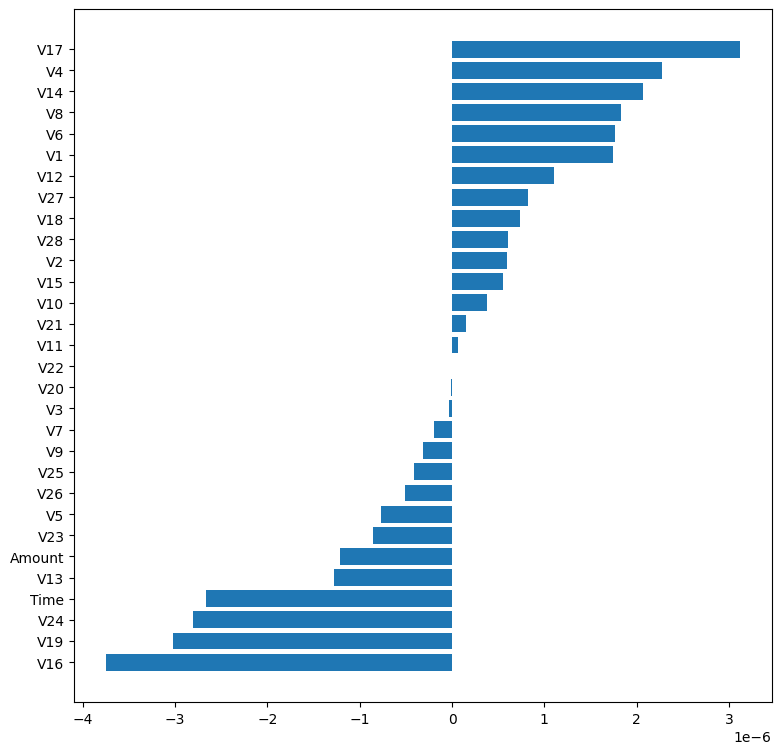

In [46]:
# Visualize the Feature Attributions
# Import necessary libraries for visualization.
import matplotlib.pyplot as plt
# Initialize lists to store features and their scores.
features = []
scores = []
# Extract feature attributions from the explanation.
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))] # Sort the features by their scores for better visualization.
scores = sorted(scores)
# Create a bar plot to visualize the feature attributions.
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

####  **Interpretation of the Bar Chart**
The Bar Chart above shows the feature attributions for a particular prediction made by the model. Here's a detailed interpretation of the chart:
- Horizontal Axis (Attribution Score) : The horizontal axis represents the attribution scores, which indicate the contribution of each feature to the model's prediction.
- Positive scores suggest that the feature contributes positively to the prediction (i.e., increasing the likelihood of the predicted class).
- Negative scores suggest that the feature contributes negatively to the prediction (i.e., decreasing the likelihood of the predicted class).
- The vertical axis lists the features from the dataset.
- Each bar corresponds to a feature and its length represents the magnitude of its attribution score.

**Example : (Your results could be different)**

**Top Contributing Features:**
- V17: The feature **V17** has the highest positive attribution score, indicating it is the most influential feature in driving the model's prediction towards the predicted class.
- V4 : Similarly, **V4** is also a significant positive contributor.

**Features with Lower Impact :**
-  Features like **V16** and **V19** have negative attribution scores, indicating they negatively impact the prediction. This means that higher values of these features reduce the likelihood of the predicted class.

**Neutral or Low-Impact Features :**
- Features closer to zero, such as **V22** and **V20**, have minimal impact on the prediction. They neither strongly support nor oppose the predicted outcome.




## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations
This section creates a batch prediction job that reads data from a BigQuery table, makes predictions using the deployed model, and writes the results back to BigQuery.


In [47]:
# this job would take +2 hours,  depending on your infrastcuture
# Create a batch prediction job to run predictions on a large dataset stored in BigQuery and save the results back to BigQuery.
# job_display_name: A descriptive name for the batch prediction job, useful for identifying it in the Vertex AI console.
# model_name : The name of the deployed model to be used for making predictions.
# instances_format : Specifies the format of the input data. Here, it is set to "bigquery" because the input data is in a BigQuery table.
# predictions_format : Specifies the format of the output predictions. Here, it is set to "bigquery" to store the predictions back in BigQuery.
# bigquery_source : The path to the BigQuery table that contains the input data.
# bigquery_destination_prefix : The project ID where the prediction results will be stored.
# generate_explanation : If set to True, the job will generate explanations for the predictions, providing insights into the model's decision-making process.
# labels :  Metadata labels for organizing and managing the job.

batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/292219499736/locations/us-central1/batchPredictionJobs/7950933927546322944
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/292219499736/locations/us-central1/batchPredictionJobs/7950933927546322944')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/7950933927546322944?project=292219499736
BatchPredictionJob projects/292219499736/locations/us-central1/batchPredictionJobs/7950933927546322944 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/292219499736/locations/us-central1/batchPredictionJobs/7950933927546322944 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/292219499736/locations/us-central1/batchPredictionJobs/7950933927546322944 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/292219499736/locations/us-central1/batchPredictionJobs/